<a href="https://colab.research.google.com/github/nihil21/cnn-deblur/blob/extra-level/cnn-deblur/cnn-deblur.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# cnn-deblur

This project aims at developing a Deep Neural Network able to deblur images, as part of the **Deep Learning** cours of the **Master in Artificial Intelligence** (*Alma Mater Studiorum*).  
This DNN should be able to correct both gaussian and motion blur, by training on Cifar10 and REDS datasets.

#### Authors:
 - Mattia Orlandi
 - Giacomo Pinardi

## Premises
Mount Google Drive to save checkpoints.

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Prepare callback function to save weights to Drive.

In [0]:
from tensorflow.keras.callbacks import Callback, ModelCheckpoint

folder = input('Folder: ')
filepath='/content/drive/My Drive/cnn-deblur/' + folder + '/ep:{epoch:03d}-val_acc:{val_accuracy:.3f}.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

Folder: batch2_decay


Enable TPU to speed up the processing; in case the notebook is not connected to a TPU runtime, it falls back to GPU.  
If that fails too, an exception is raised.

In [0]:
%tensorflow_version 2.x
import tensorflow as tf
import os

if 'COLAB_TPU_ADDR' not in os.environ:
  TPU = False
  print('ERROR: Not connected to a TPU runtime; trying to enable GPU support')
  device_name = tf.test.gpu_device_name()
  if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found, aborting...')
  print('Found GPU at: {}'.format(device_name))
else:
  TPU = True
  tpu_address = 'grpc://' + os.environ['COLAB_TPU_ADDR']
  tf.config.experimental_connect_to_host('grpc://' + os.environ['COLAB_TPU_ADDR'])
  print ('TPU address is', tpu_address)
  resolver = tf.distribute.cluster_resolver.TPUClusterResolver('grpc://' + os.environ['COLAB_TPU_ADDR'])
  tf.tpu.experimental.initialize_tpu_system(resolver)
  strategy = tf.distribute.experimental.TPUStrategy(resolver)

ERROR: Not connected to a TPU runtime; trying to enable GPU support
Found GPU at: /device:GPU:0


Connect to GitHub, download the required Python modules from the repository.

In [0]:
from getpass import getpass
import urllib

# Change working directory
os.chdir('/content')

# Remove all directory
! rm -r 'cnn-deblur'

# Read credentials to GitHub
user = input('User name: ')
password = getpass('Password: ')
password = urllib.parse.quote(password)
branch = input('Branch: ')

cmd_string = 'git clone -b {0:s} https://{1:s}:{2:s}@github.com/nihil21/cnn-deblur.git'.format(branch, user, password)

os.system(cmd_string)
cmd_string, password = "", ""

User name: nihil21
Password: ··········
Branch: no-dense


Change working directory.

In [0]:
# Move inside cloned repository
os.chdir(os.path.join('cnn-deblur', 'cnn-deblur'))

Import the Python modules and other relevant libraries.

In [0]:
from model.conv_net import ConvNet
from utils.preproc_cifar import preproc_cifar10
from keras.utils import model_to_dot
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

Using TensorFlow backend.


## 1. Cifar10
Preprocess the Cifar10 dataset by blurring images with a random standard deviation and reserve samples for validation.

In [0]:
# Preprocess Cifar10 dataset
(trainX, trainY), (testX, testY) = preproc_cifar10(res=(1280, 720), normalize=True)
# Reserve samples for validation
valX = trainX[-10000:]
valY = trainY[-10000:]

print('Training set size: {0:d}'.format(trainX.shape[0]))
print('Validation set size: {0:d}'.format(valX.shape[0]))
print('Test set size: {0:d}'.format(testX.shape[0]))

Time elapsed: 3.56 s
Training set size: 50000
Validation set size: 10000
Test set size: 10000


Create a ConvNet object suited for the Cifar10 dataset and plot its structure.

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv (Conv2D)                   (None, 32, 32, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
conv1_1.1 (Conv2D)              (None, 32, 32, 16)   2320        conv[0][0]                       
__________________________________________________________________________________________________
conv1_1.2 (Conv2D)              (None, 32, 32, 16)   2320        conv1_1.1[0][0]                  
______________________________________________________________________________________________

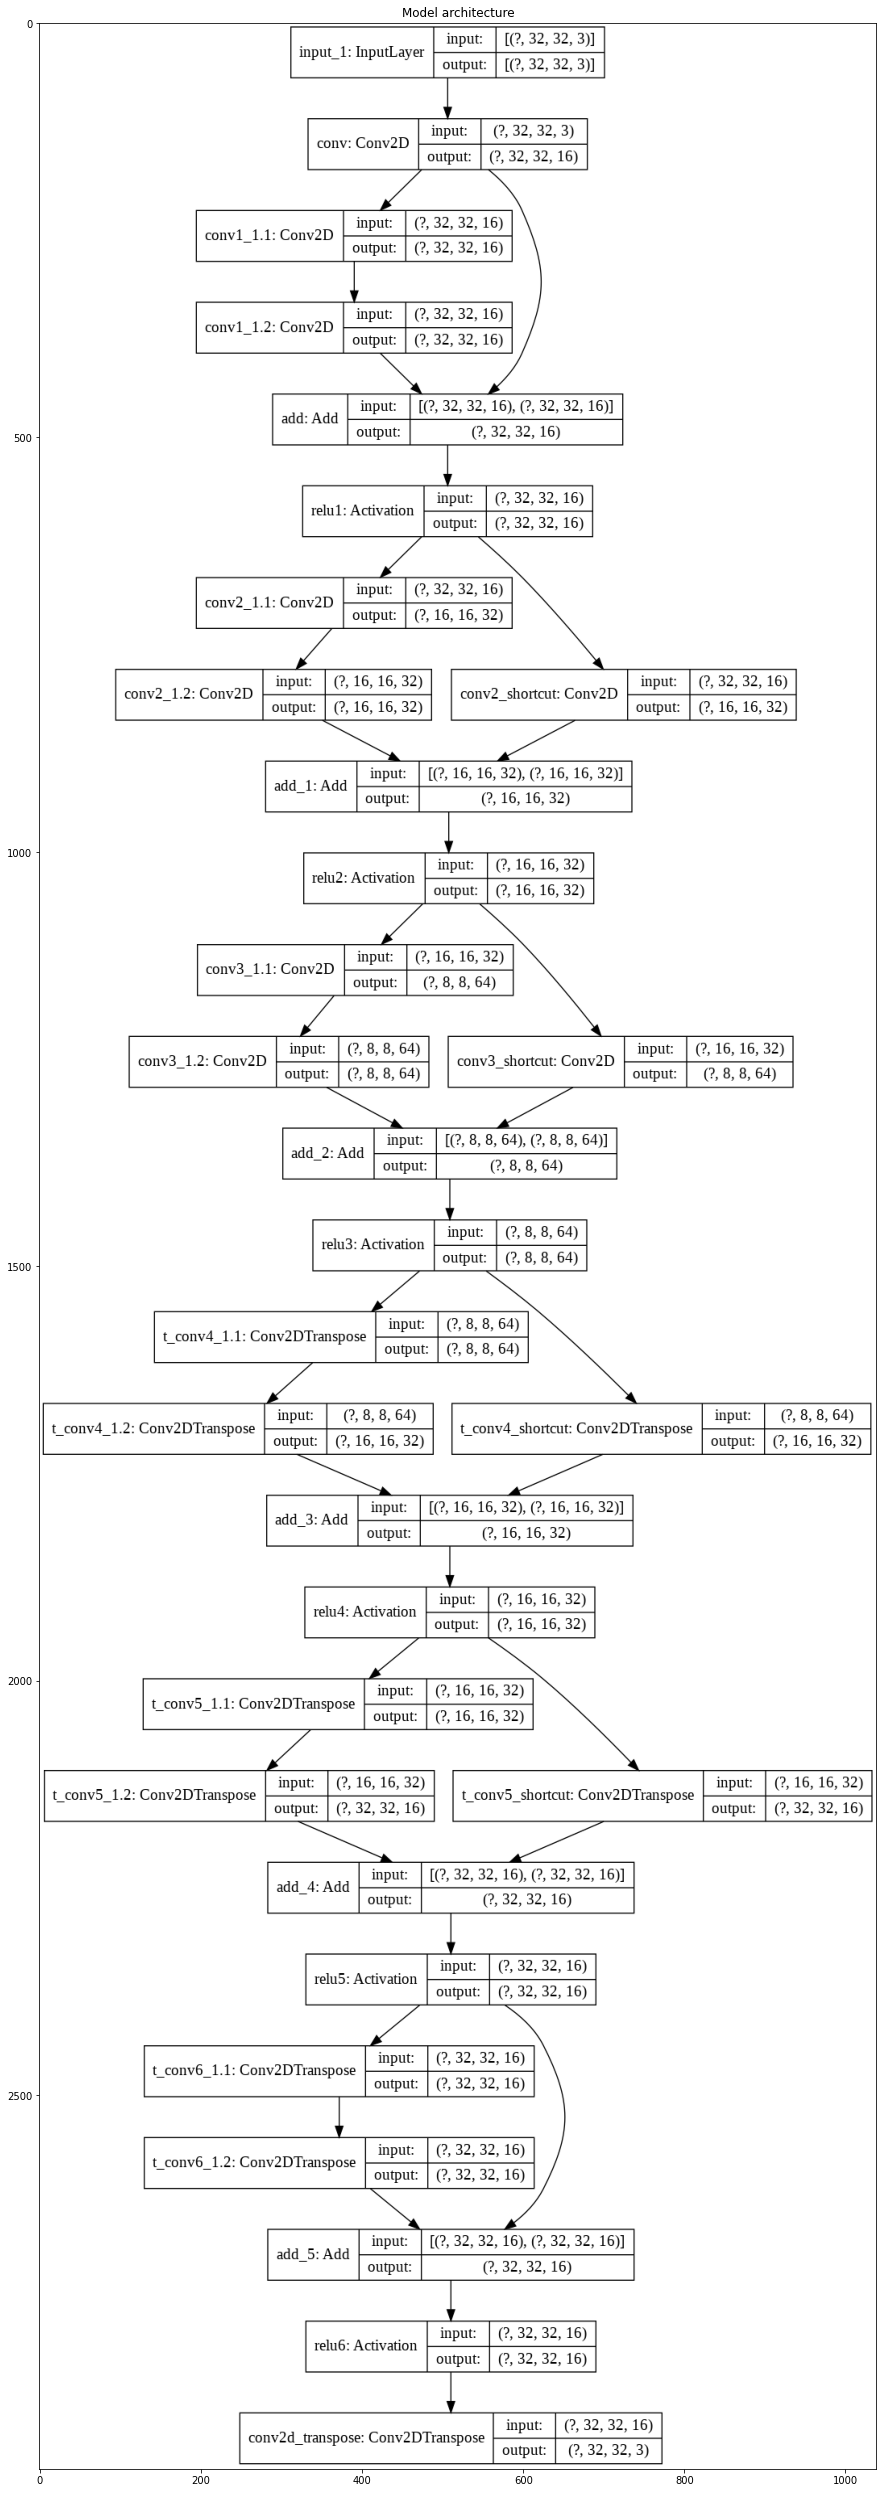

In [0]:
# Create ResNet and plot model
if TPU:
  tf.compat.v1.disable_eager_execution()
  with strategy.scope():
    conv_net = ConvNet(input_shape=(32, 32, 3))
else:
  conv_net = ConvNet(input_shape=(32, 32, 3))

print(conv_net.summary())
path_to_model = os.path.join('..', 'res', 'model.png')
conv_net.plot_model(path_to_model)
fig, ax = plt.subplots(figsize=(15, 45))
ax.set_title('Model architecture')
plt.imshow(mpimg.imread(path_to_model), aspect='auto');

Load weights from previous run.

In [0]:
import glob

folder = input('Folder: ')
init_ep = int(input('Initial epoch: '))

weights = glob.glob('/content/drive/My Drive/cnn-deblur/{0:s}/ep:{1:03d}-val_acc:*.hdf5'.format(folder, init_ep))
conv_net.model.load_weights(weights[0])

Folder: batch2
Initial epoch: 37


Train model following *train-validation-test* paradigm.

In [0]:
ep = 50
if 'init_ep' not in locals():
  init_ep = 0
print('Initial epoch: {0:d}'.format(init_ep))
hist = conv_net.fit(x=trainX, y=trainY,
                    batch_size=2,
                    epochs=ep,
                    validation_data=(valX, valY),
                    initial_epoch=init_ep,
                    callbacks=callbacks_list);

Initial epoch: 0
Epoch 1/50
24994/25000 [============================>.] - ETA: 0s - loss: -0.7974 - accuracy: 0.5484
Epoch 00001: val_accuracy improved from -inf to 0.62298, saving model to /content/drive/My Drive/cnn-deblur/batch2_decay/ep:001-val_acc:0.623.hdf5
25000/25000 [==============================] - 146s 6ms/step - loss: -0.7974 - accuracy: 0.5484 - val_loss: -0.8242 - val_accuracy: 0.6230
Epoch 2/50
 1647/25000 [>.............................] - ETA: 2:10 - loss: -0.8250 - accuracy: 0.6227

Evaluate the model on the test set.

In [0]:
results = conv_net.model.evaluate(testX, testY, batch_size=2)
print('Test loss, Test acc:', results)

5000/5000 [==============================] - 15s 3ms/step - loss: -0.9278 - accuracy: 0.8549
Test loss, Test acc: [-0.9278203248977661, 0.8549309372901917]


Plot graph representing the loss and accuracy trends over epochs.

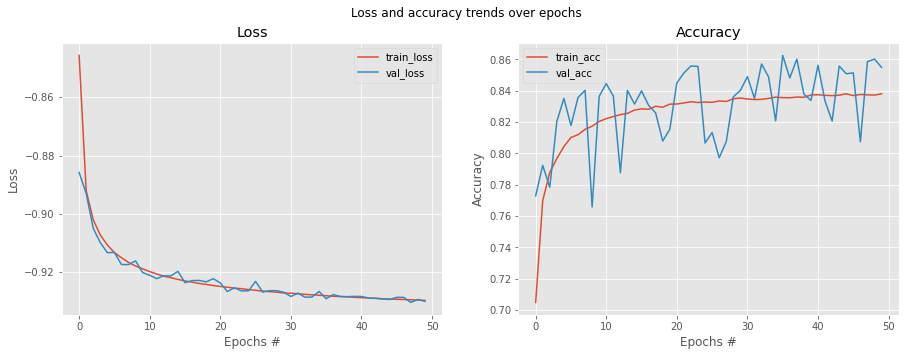

In [0]:
n = np.arange(0, ep)
plt.style.use('ggplot')
fig, (ax_l, ax_a) = plt.subplots(ncols=2, figsize=(15, 5))
fig.suptitle('Loss and accuracy trends over epochs')
# Loss
ax_l.plot(n, hist.history['loss'], label='train_loss')
ax_l.plot(n, hist.history['val_loss'], label='val_loss')
ax_l.set_title('Loss')
ax_l.set(xlabel='Epochs #', ylabel='Loss')
ax_l.legend();
# Accuracy
ax_a.plot(n, hist.history['accuracy'], label='train_acc')
ax_a.plot(n, hist.history['val_accuracy'], label='val_acc')
ax_a.set_title('Accuracy')
ax_a.set(xlabel='Epochs #', ylabel='Accuracy')
ax_a.legend();

Generate predictions on new data.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


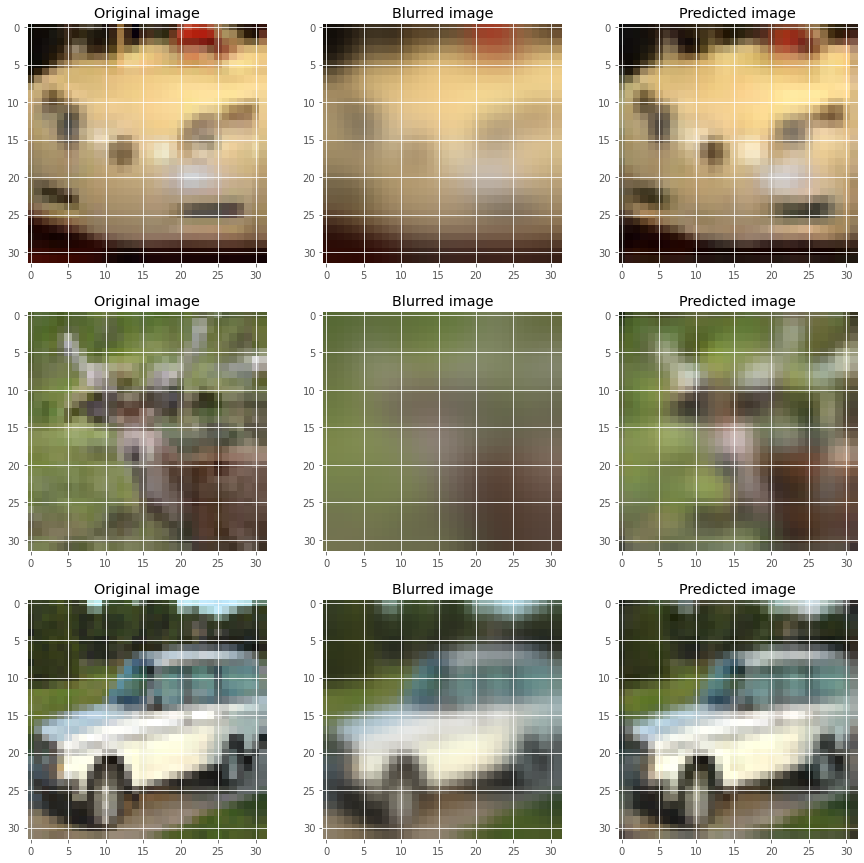

In [0]:
idx = np.random.randint(low=0, high=len(testX), size=3)
blurred = testX[idx]
original = testY[idx]

predicted = conv_net.predict(testX[idx])

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))
for i in range(3):
  axes[i, 0].set_title('Original image')
  axes[i, 0].imshow(original[i]);
  axes[i, 1].set_title('Blurred image')
  axes[i, 1].imshow(blurred[i]);
  axes[i, 2].set_title('Predicted image')
  axes[i, 2].imshow(predicted[i]);